<a href="https://colab.research.google.com/github/tyukei/LLMs-from-scratch/blob/japanese/ch04/01_main-chapter-code/ch04_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
<a href = "http://mng.bz/oryv"の補足コード>ゼロから大きな言語モデルを構築</a> <a href = "https://sebastianraschka.com"> sebastian raschka </a> <br><br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

＃第4章：ゼロからGPTモデルを実装してテキストを生成する

In [1]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.6.0+cu124
tiktoken version: 0.9.0


- この章では、GPTのようなLLMアーキテクチャを実装します。次の章では、このLLMのトレーニングに焦点を当てます

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 LLMアーキテクチャのコーディング

- 第1章では、GPTやLlamaなどのモデルについて説明します。これは、単語を順番に生成し、元のトランスアーキテクチャのデコーダー部分に基づいています
- したがって、これらのLLMはしばしば「デコーダーのような」LLMと呼ばれます
- 従来のディープラーニングモデルと比較して、LLMは主にコードの量ではなく、膨大な数のパラメーターのために大きいです
- 多くの要素がLLMのアーキテクチャで繰り返されていることがわかります

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- 前の章では、トークンの入力と出力に小さな埋め込み寸法を使用して、イラストを容易にし、それらが単一のページに適合するようにします
- この章では、小さなGPT-2モデルに似た埋め込みとモデルサイズを検討します
-Radford et al。の__link_placeholder_0__で概説されているように、最小のGPT-2モデル（1億4,400万パラメーター）のアーキテクチャを具体的にコーディングします（最初のレポートには117mパラメーターとしてリストされていることに注意してください。
- 第6章では、345、762、および1542百万のパラメーターのモデルサイズと互換性のある実装に、前処理された重量を実装にロードする方法を示します。

-1億2,400万のパラメーターGPT-2モデルの構成詳細は次のとおりです。

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

- 短い変数名を使用して、後で長い行のコードを避けます
-  `" vocab_size "`は、第2章で説明したBPEトークナイザーによってサポートされる50,257語の語彙サイズを示します。
-  `" context_length "`は、第2章でカバーされている位置埋め込みによって有効にされているモデルの最大入力トークンカウントを表します
-  `" emb_dim "`はトークン入力の埋め込みサイズであり、各入力トークンを768次元ベクトルに変換します
-  `" n_heads "`は、第3章で実装されているマルチヘッドの注意メカニズムの注意ヘッドの数です
-  `" n_layers "`はモデル内の変圧器ブロックの数であり、今後のセクションで実装します
-  `" drop_rate "`は、第3章で説明したドロップアウトメカニズムの強度です。0.1は、過剰適合を緩和するためにトレーニング中に隠されたユニットの10％を落とすことを意味します
-  `" qkv_bias "`マルチヘッド注意メカニズムの「線形」層（第3章から）が、計算クエリ（q）、キー（k）、および値（v）テンソルの際にバイアスベクターを含める必要があるかどうかを決定します。このオプションは無効になります。これは、現代のLLMで標準的な慣行です。ただし、第5章で再実装にオープンアイから前提条件のGPT-2ウェイトをロードすると、後でこれを再検討します

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [3]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


---

**注記**

- このコードをWindowsまたはLinuxで実行している場合、上記の値は次のように見える場合があります。

`` `
出力形状：torch.size（[2、4、50257]）
テンソル（[[[ -  0.9289、0.2748、-0.7557、...、-1.6070、0.2702、-0.5888]、
[-0.4476、0.1726、0.5354、...、-0.3932、1.5285、0.8557]、
[0.5680、1.6053、-0.2155、...、1.1624、0.1380、0.7425]、
[0.0447、2.4787、-0.8843、...、1.3219、-0.0864、-0.5856]、

[[-1.5474、-0.0542、-1.0571、...、-1.8061、-0.4494、-0.6747]、
[-0.8422、0.8243、-0.1098、...、-0.1434、0.2079、1.2046]、
[0.1355、1.1858、-0.1453、...、0.0869、-0.1590、0.1552]、
[0.1666、-0.8138、0.2307、...、2.5035、-0.3055、-0.3083]]、
grad_fn = <unsafeviewbackward0>）
`` `

- これらは乱数にすぎないため、これは懸念の理由ではなく、問題なく残りの章を進めることができます
- この矛盾の考えられる理由の1つは、Pytorchの編集方法に応じて、オペレーティングシステム全体で「nn.dropout」の異なる動作です。

---

## 4.2レイヤー正規化によるアクティブ化の正規化

-Layernorm（__Link_PlaceHolder_0__）とも呼ばれるレイヤー正規化は、ニューラルネットワーク層の活性化を平均0の周りに中心にし、その分散を1に正規化します
- これにより、トレーニングが安定し、効果的なウェイトへのより速い収束が可能になります
- レイヤー正規化は、変圧器ブロック内のマルチヘッド注意モジュールの前後の両方で適用され、後で実装します。また、最終出力層の前に適用されます

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- 単純なニューラルネットワークレイヤーに小さな入力サンプルを渡すことにより、層の正規化がどのように機能するかを見てみましょう。

In [6]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 上記の2つの入力のそれぞれの平均と分散を計算しましょう。

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 正規化は、2つの入力（行）のそれぞれに個別に適用されます。dim = -1を使用すると、行の寸法の代わりに、最後の次元（この場合は特徴寸法）に計算が適用されます

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- 平均を差し引き、分散の平方根（標準偏差）で除算すると、入力が中心になり、平均は0、列（特徴）寸法全体で1の分散が1になります。

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 各入力は0の中心で、単位分散は1です。読みやすさを改善するために、Pytorchの科学表記法を無効にすることができます。

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 上記では、各入力の機能を正規化しました
- ここで、同じアイデアを使用して、「layernorm」クラスを実装できます。

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**スケールとシフト**

- 平均を差し引き、分散で除算することで正規化を実行することに加えて、2つのトレーニング可能なパラメーター、「スケール」と「シフト」パラメーターを追加したことに注意してください。
- 初期「スケール」（1を掛ける）と「シフト」（0の追加）値には効果がありません。ただし、「スケール」と「シフト」は、トレーニングタスクでのモデルのパフォーマンスが改善されると判断された場合、LLMがトレーニング中に自動的に調整するトレーニング可能なパラメーターです。
- これにより、モデルは適切なスケーリングとシフトを学習し、処理しているデータに最適なシフトを実行できます。
- 分散の平方根を計算する前に、より小さな値（ `eps`）も追加することに注意してください。これは、分散が0の場合、ディビジョンごとのエラーを避けるためです

**偏った分散**
- 上記の分散計算では、 `biased = false`を設定することは、式$ \ frac {\ sum_i（x_i  -  \ bar {x}）^2} {n} $を使用して、nがサンプルサイズ（ここでは機能または列の数）を計算することを意味します。この式には、ベッセルの補正（分母に「n-1」を使用）は含まれていないため、分散の偏った推定値が提供されます。
-LLMSの場合、埋め込み寸法 `n`は非常に大きく、nと` n-1 `の使用の違いは
無視できます
- ただし、GPT-2は正規化層の偏りのある分散で訓練されたため、後の章でロードする前提条件の重みと互換性の理由でこの設定を採用しました。

- 実際に「layernorm」を試してみましょう：

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [12]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

##4.3 GELUアクティベーションを使用してフィードフォワードネットワークを実装する

- このセクションでは、LLMSの変圧器ブロックの一部として使用される小さなニューラルネットワークサブモジュールを実装します
- アクティベーション関数から始めます
- 深い学習では、さまざまなニューラルネットワークアーキテクチャにおける単純さと有効性のために、relu（整流線形単位）活性化関数が一般的に使用されます
-LLMSでは、他のさまざまなタイプの活性化関数が従来のリレーションを超えて使用されています。2つの注目すべき例は、Gelu（Gaussian Errer Linearユニット）とSwiglu（スイッシュ依存性線形ユニット）です。
-GELUとSwigluは、それぞれガウスとシグモイドの線形ユニットを組み込んだより複雑で滑らかな活性化機能であり、Reluのよりシンプルで区分的な線形関数とは異なり、ディープラーニングモデルのパフォーマンスを向上させることができます。

-GELU（__link_placeholder_0__）はいくつかの方法で実装できます。正確なバージョンは、gelu（x）=x⋅φ（x）として定義されます。ここで、φ（x）は標準ガウス分布の累積分布関数です。
- 実際には、計算的に安価な近似を実装することが一般的です：$ \ text {gelu}（x）\ cdot x \ cdot \ left（1 + \ tanh \ left [\ sqrt {\ frac {2} {\ pi}} \ cdot \ left \ left（x + 0.044715x^3 \右）\右] \右）
$（元のGPT-2モデルもこの近似でトレーニングされました）

In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

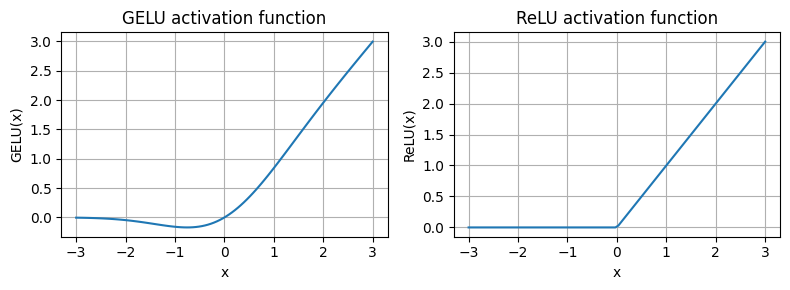

In [14]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 私たちが見ることができるように、Reluは、それが正である場合、入力を直接出力する区分的線形関数です。それ以外の場合、ゼロを出力します
-GELUは、reluに近似する滑らかで非線形の関数ですが、負の値に対して非ゼロ勾配を使用します（約-0.75を除く）

- 次に、LLMの変圧器ブロックで使用する小さなニューラルネットワークモジュール「FeedForward」を実装しましょう。

In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [17]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4ショートカット接続の追加

- 次に、Skipまたは残留接続とも呼ばれるショートカット接続の背後にある概念について話しましょう
- 元々、ショートカット接続は、消失勾配の問題を軽減するためのコンピュータービジョン（残留ネットワーク）のディープネットワークで提案されていました
- ショートカット接続は、勾配がネットワークを流れるための代替の短いパスを作成します
- これは、1つのレイヤーの出力を後のレイヤーの出力に追加することで達成され、通常は1つ以上のレイヤーをスキップする
- このアイデアを小さな例ネットワークで説明しましょう。<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- コードでは、次のようになります。

In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 最初にグラデーション値を印刷しましょう** **ショートカット接続：

In [19]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- 次に、勾配値を印刷してください** **ショートカット接続：

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- 上記の出力に基づいてわかるように、ショートカット接続により、勾配が初期層で消えるのを防ぎます（ 'layer.0`に向かって）
- 変圧器ブロックを実装するときに、次にショートカット接続のこの概念を使用します

## 4.5トランスブロック内の注意と線形層の接続

- このセクションでは、以前の概念をいわゆる変圧器ブロックに組み合わせています
- 変圧器ブロックは、前の章からの因果的なマルチヘッド注意モジュールを線形層、前のセクションで実装したフォワードフォワードニューラルネットワークと組み合わせます
- さらに、変圧器ブロックはドロップアウトとショートカット接続も使用します

In [21]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

ModuleNotFoundError: No module named 'previous_chapters'

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- それぞれ6つのトークンを備えた2つの入力サンプルがあるとします。各トークンは768次元の埋め込みベクトルです。次に、この変圧器ブロックは自己触媒を適用し、次に線形層が続き、同様のサイズの出力を生成します
- 出力は、前の章で説明したコンテキストベクターの拡張バージョンと考えることができます

In [ ]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 GPTモデルのコーディング

- 私たちはほとんどそこにいます：次に、この章の最初にコーディングしたアーキテクチャに変圧器ブロックをプラグインして、使用可能なGPTアーキテクチャを取得するようにしましょう
- 変圧器ブロックは複数回繰り返されることに注意してください。最小の124M GPT-2モデルの場合、12回繰り返します。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- 対応するコードの実装、 `cfg [" n_layers "] = 12`：

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

-124Mパラメーターモデルの構成を使用して、次のようにランダムな初期重みでこのGPTモデルをインスタンス化できるようになりました。

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

- 次の章でこのモデルをトレーニングします
- ただし、そのサイズに関する簡単なメモ：以前に124mパラメーターモデルと呼んでいました。次のように、この番号を再確認できます。

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

- 上記のように、このモデルには124mパラメーターではなく163mがあります。なぜ？
- 元のGPT-2ペーパーでは、研究者は重量を適用しました。つまり、トークン埋め込み層（ `tok_emb`）を出力層として再利用することを意味します。
- トークン埋め込み層は、50,257次元の1ホットエンコード入力トークンを768次元の埋め込み表現に投影します
- 出力層は768次元の埋め込みを50,257次元表現に戻し、これらを言葉に戻すことができます（次のセクションではそれについて詳しく説明します）
- したがって、埋め込み層と出力層には、重量マトリックスの形状に基づいてわかるように、同じ数の重みパラメーターがあります。
- ただし、そのサイズに関する簡単なメモ：以前に124mパラメーターモデルと呼んでいました。次のように、この番号を再確認できます。

In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

- 元のGPT-2ペーパーで、研究者はトークン埋め込みマトリックスを出力マトリックスとして再利用しました
- それに応じて、出力層のパラメーターの数を差し引いた場合、124mパラメーターモデルを取得します。

In [ ]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

- 実際には、体重を作らずにモデルを訓練する方が簡単だと感じたので、ここで実装しませんでした
- ただし、第5章で前提条件の重みをロードするときに、この重量タイイングのアイデアを再訪して適用します。
- 最後に、次のようにモデルのメモリ要件を計算できます。これは、役立つ基準点になる可能性があります。

In [ ]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

- 演習：__link_placeholder_0__でも参照される他の構成を試すことができます。

-  ** gpt2-small **（すでに実装した124m構成）：
-  "emb_dim" = 768
- 「n_layers」= 12
- 「n_heads」= 12

-  ** gpt2-medium：**
-  "emb_dim" = 1024
- 「n_layers」= 24
- 「n_heads」= 16

-  ** gpt2-large：**
-  "emb_dim" = 1280
- 「n_layers」= 36
- 「n_heads」= 20

-  ** gpt2-xl：**
-  "emb_dim" = 1600
- 「n_layers」= 48
- 「n_heads」= 25

## 4.7テキストの生成

- 上記で実装したGPTモデルのようなLLMSは、一度に1つの単語を生成するために使用されます

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- 次の「Generate_text_simple`関数は貪欲なデコードを実装します。これはテキストを生成するためのシンプルで高速な方法です
- 貪欲なデコードでは、各ステップで、モデルは次の出力として最高の確率で単語（またはトークン）を選択します（最高のロジットは最高の確率に対応するため、技術的にはSoftMax関数を明示的に計算する必要さえありません）
- 次の章では、より高度な `generate_text`関数を実装します
- 以下の図は、入力コンテキストが与えられたGPTモデルが次の単語トークンを生成する方法を示しています

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- 上記の「Generate_text_simple`は、一度に1つのトークンを作成する反復プロセスを実装します<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- 入力例を準備しましょう：

In [ ]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

In [ ]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

- バッチディメンションを削除し、テキストに戻します。

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

- モデルが訓練されていないことに注意してください。したがって、上記のランダム出力テキスト
- 次の章でモデルをトレーニングします

##概要とテイクアウト

-  __link_placeholder_0__スクリプトを参照してください。
-  __link_placeholder_1__でエクササイズソリューションを見つけることができます